In [1]:
import numpy as np
from scipy.fft import fft2, ifft2
import matplotlib.pyplot as plt

In [2]:
# # Pseudospectral solver parameters
# Nx_fine = 128  # Fine-scale resolution
# Ny_fine = 128
# Nx_coarse = 48  # Coarse-scale resolution
# Ny_coarse = 48
# Lx, Ly = 100.0, 100.0  # Domain size
# dt = 0.1  # Time step
# Nt = 12500  # Number of time steps

# # Diffusion and reaction parameters
# D_u = 0.16
# D_v = 0.08
# F = 0.04
# k = 0.06

# # Initialize spatial grids for fine and coarse resolutions
# x_fine = np.linspace(0, Lx, Nx_fine, endpoint=False)
# y_fine = np.linspace(0, Ly, Ny_fine, endpoint=False)
# x_coarse = np.linspace(0, Lx, Nx_coarse, endpoint=False)
# y_coarse = np.linspace(0, Ly, Ny_coarse, endpoint=False)

# kx_fine = 2 * np.pi * np.fft.fftfreq(Nx_fine, d=(Lx / Nx_fine))
# ky_fine = 2 * np.pi * np.fft.fftfreq(Ny_fine, d=(Ly / Ny_fine))
# kx_coarse = 2 * np.pi * np.fft.fftfreq(Nx_coarse, d=(Lx / Nx_coarse))
# ky_coarse = 2 * np.pi * np.fft.fftfreq(Ny_coarse, d=(Ly / Ny_coarse))

# Kx_fine, Ky_fine = np.meshgrid(kx_fine, ky_fine, indexing='ij')
# Kx_coarse, Ky_coarse = np.meshgrid(kx_coarse, ky_coarse, indexing='ij')

# # Initialize fields in physical space
# U_fine =  np.ones((Nx_fine, Ny_fine))#np.sin(Kx_fine) * np.cos(Ky_fine) * np.exp(-(Kx_fine - 0.5) ** 2) * np.exp(-(Ky_fine - 0.5) ** 2)#np.ones((Nx_fine, Ny_fine))
# V_fine = np.zeros((Nx_fine, Ny_fine))
# #U_fine[Nx_fine // 4:Nx_fine // 4 * 3, Ny_fine // 4:Ny_fine // 4 * 3] = 0.4
# #V_fine[Nx_fine // 4:Nx_fine // 4 * 3, Ny_fine // 4:Ny_fine // 4 * 3] = 0.3

# U_coarse = np.ones((Nx_coarse, Ny_coarse))
# V_coarse = np.zeros((Nx_coarse, Ny_coarse))
# U_coarse[Nx_coarse // 4:Nx_coarse // 4 * 3, Ny_coarse // 4:Ny_coarse // 4 * 3] = 0.4
# V_coarse[Nx_coarse // 4:Nx_coarse // 4 * 3, Ny_coarse // 4:Ny_coarse // 4 * 3] = 0.3

In [3]:
# Pseudospectral solver parameters
Nx_fine = 128  # Fine-scale resolution
Ny_fine = 128
Nx_coarse = 48  # Coarse-scale resolution
Ny_coarse = 48
Lx, Ly = 100.0, 100.0  # Domain size
dt = 0.01  # Time step
Nt = 50  # Number of time steps

# Diffusion and reaction parameters
D_u = 0.16
D_v = 0.08
F = 0.04
k = 0.06

# Initialize spatial grids for fine and coarse resolutions
x_fine = np.linspace(0, Lx, Nx_fine, endpoint=False)
y_fine = np.linspace(0, Ly, Ny_fine, endpoint=False)
x_coarse = np.linspace(0, Lx, Nx_coarse, endpoint=False)
y_coarse = np.linspace(0, Ly, Ny_coarse, endpoint=False)

# Generate meshgrid for spatial domain
X_fine, Y_fine = np.meshgrid(x_fine, y_fine)
X_coarse, Y_coarse = np.meshgrid(x_coarse, y_coarse)
kx_fine = 2 * np.pi * np.fft.fftfreq(Nx_fine, d=(Lx / Nx_fine))
ky_fine = 2 * np.pi * np.fft.fftfreq(Ny_fine, d=(Ly / Ny_fine))
kx_coarse = 2 * np.pi * np.fft.fftfreq(Nx_coarse, d=(Lx / Nx_coarse))
ky_coarse = 2 * np.pi * np.fft.fftfreq(Ny_coarse, d=(Ly / Ny_coarse))

Kx_fine, Ky_fine = np.meshgrid(kx_fine, ky_fine, indexing='ij')
Kx_coarse, Ky_coarse = np.meshgrid(kx_coarse, ky_coarse, indexing='ij')

In [10]:
import warnings
from tqdm import trange

total_fine_scale_dynamics = []
total_coarse_scale_dynamics = []

# Function to filter overflow warnings
def overflow_warning_filter(record):
    return issubclass(record.category, RuntimeWarning) and "overflow encountered" in str(record.message)

for _ in trange(1500):
    # Parameters for the random smooth function
    num_terms = 20  # Number of random Fourier terms
    sigma = 2  # Standard deviation for the Gaussian envelope

    # Generate random Fourier coefficients for fine grid
    A_fine = np.random.uniform(-1, 1, (num_terms, num_terms))

    # Create a Gaussian envelope in the spatial domain
    gaussian_envelope_fine = np.exp(-((X_fine - Lx / 2)**2 + (Y_fine - Ly / 2)**2) / (2 * sigma**2))

    # Generate random smooth function for U_fine using trigonometric terms and Gaussian envelope
    U_fine = np.zeros_like(X_fine)

    for i in range(num_terms):
        for j in range(num_terms):
            U_fine += A_fine[i, j] * np.sin((i + 1) * np.pi * X_fine / Lx) * np.cos((j + 1) * np.pi * Y_fine / Ly)

    U_fine *= gaussian_envelope_fine

    # Initialize V_fine as zero, or use another function
    V_fine = 0.2 * U_fine

    # Generate random Fourier coefficients for the coarse grid
    A_coarse = A_fine

    # Create a Gaussian envelope in the spatial domain for coarse grid
    gaussian_envelope_coarse = np.exp(-((X_coarse - Lx / 2)**2 + (Y_coarse - Ly / 2)**2) / (2 * sigma**2))

    # Generate random smooth function for U_coarse using trigonometric terms and Gaussian envelope
    U_coarse = np.zeros_like(X_coarse)

    for i in range(num_terms):
        for j in range(num_terms):
            U_coarse += A_coarse[i, j] * np.sin((i + 1) * np.pi * X_coarse / Lx) * np.cos((j + 1) * np.pi * Y_coarse / Ly)

    U_coarse *= gaussian_envelope_coarse

    # Initialize V_coarse as zero, or use another function
    V_coarse = 0.2 * U_coarse

    # Store dynamics
    fine_scale_dynamics = np.zeros((Nt, Nx_fine, Ny_fine))
    coarse_scale_dynamics = np.zeros((Nt, Nx_coarse, Ny_coarse))

    overflow_detected = False  # Flag to track overflow

    # Time-stepping loop
    with warnings.catch_warnings(record=True) as w:
        warnings.simplefilter("always")  # Capture all warnings
        for n in range(Nt):
            # Fine-scale solver
            U_hat_fine = fft2(U_fine)
            V_hat_fine = fft2(V_fine)

            laplacian_fine = -(Kx_fine**2 + Ky_fine**2)
            U_hat_fine += dt * (D_u * laplacian_fine * U_hat_fine - fft2(U_fine * V_fine**2) + fft2(F * (1 - U_fine)))
            V_hat_fine += dt * (D_v * laplacian_fine * V_hat_fine + fft2(U_fine * V_fine**2) - fft2((F + k) * V_fine))

            U_fine = np.real(ifft2(U_hat_fine))
            V_fine = np.real(ifft2(V_hat_fine))
            fine_scale_dynamics[n] = U_fine

            # Coarse-scale solver
            U_hat_coarse = fft2(U_coarse)
            V_hat_coarse = fft2(V_coarse)

            laplacian_coarse = -(Kx_coarse**2 + Ky_coarse**2)
            U_hat_coarse += dt * (D_u * laplacian_coarse * U_hat_coarse - fft2(U_coarse * V_coarse**2) + fft2(F * (1 - U_coarse)))
            V_hat_coarse += dt * (D_v * laplacian_coarse * V_hat_coarse + fft2(U_coarse * V_coarse**2) - fft2((F + k) * V_coarse))

            U_coarse = np.real(ifft2(U_hat_coarse))
            V_coarse = np.real(ifft2(V_hat_coarse))
            coarse_scale_dynamics[n] = U_coarse

            # Check for overflow warnings
            if any(overflow_warning_filter(record) for record in w):
                print(f"Overflow detected at time step {n}. Skipping trajectory.")
                overflow_detected = True
                break  # Exit the time-stepping loop

    if overflow_detected:
        continue  # Skip to the next initial condition

    # Normalize both datasets if no overflow occurred
    fine_scale_dynamics -= np.min(fine_scale_dynamics)
    fine_scale_dynamics /= np.max(fine_scale_dynamics)

    coarse_scale_dynamics -= np.min(coarse_scale_dynamics)
    coarse_scale_dynamics /= np.max(coarse_scale_dynamics)

    fine_scale_dynamics = fine_scale_dynamics[::10]
    coarse_scale_dynamics = coarse_scale_dynamics[::10]
    # plt.imshow(fine_scale_dynamics[0])
    # plt.show()
    # plt.imshow(coarse_scale_dynamics[0])
    # plt.show()
    # plt.imshow(fine_scale_dynamics[-1])
    # plt.show()
    # plt.imshow(coarse_scale_dynamics[-1])
    # plt.show()
    if total_coarse_scale_dynamics:
        print(np.linalg.norm(coarse_scale_dynamics - total_coarse_scale_dynamics[-1]))
    total_fine_scale_dynamics.append(fine_scale_dynamics)
    total_coarse_scale_dynamics.append(coarse_scale_dynamics)


  0%|          | 2/1500 [00:00<07:11,  3.47it/s]

91.45248482297784


  0%|          | 3/1500 [00:00<07:20,  3.40it/s]

29.5303446824082


  0%|          | 4/1500 [00:01<07:11,  3.47it/s]

18.025182270598254


  0%|          | 5/1500 [00:01<07:05,  3.51it/s]

77.58331496425201


  0%|          | 6/1500 [00:01<07:03,  3.52it/s]

32.63233898129784


  0%|          | 7/1500 [00:02<07:03,  3.52it/s]

38.26532120582461


  1%|          | 8/1500 [00:02<07:03,  3.52it/s]

88.28984879069802


  1%|          | 9/1500 [00:02<06:53,  3.60it/s]

38.528171593935625


  1%|          | 10/1500 [00:02<06:56,  3.57it/s]

17.143217436370687


  1%|          | 11/1500 [00:03<06:58,  3.56it/s]

69.32590717610944


  1%|          | 12/1500 [00:03<06:58,  3.55it/s]

33.65138666253966


  1%|          | 13/1500 [00:03<06:59,  3.54it/s]

30.069734126740446


  1%|          | 14/1500 [00:03<07:00,  3.54it/s]

53.24450479544132


  1%|          | 15/1500 [00:04<06:56,  3.56it/s]

2.3604464180608753


  1%|          | 16/1500 [00:04<06:58,  3.55it/s]

44.03993725952644


  1%|          | 16/1500 [00:04<07:25,  3.33it/s]


KeyboardInterrupt: 

In [5]:
total_fine_scale_dynamics_np = np.array(total_fine_scale_dynamics)
total_coarse_scale_dynamics_np = np.array(total_coarse_scale_dynamics)
total_fine_scale_dynamics_np.shape, total_coarse_scale_dynamics_np.shape

((1447, 50, 128, 128), (1447, 50, 48, 48))

In [6]:
traj, t, x, y = total_fine_scale_dynamics_np.shape
total_fine_scale_dynamics_np = total_fine_scale_dynamics_np.reshape((traj * t, x, y))
traj, t, x, y = total_coarse_scale_dynamics_np.shape
total_coarse_scale_dynamics_np = total_coarse_scale_dynamics_np.reshape((traj * t, x, y))
total_fine_scale_dynamics_np.shape, total_coarse_scale_dynamics_np.shape

((72350, 128, 128), (72350, 48, 48))

In [7]:
with open(f'/pscratch/sd/h/hbassi/GS_model_multi_traj_data_fine_scale_dynamics_1500_tmax=5_sigma={sigma}_numterms={num_terms}.npy', 'wb') as f:
    np.save(f, np.expand_dims(total_fine_scale_dynamics_np, 1))

In [8]:
with open(f'/pscratch/sd/h/hbassi/GS_model_multi_traj_data_coarse_scale_dynamics_1500_tmax=5_sigma={sigma}_numterms={num_terms}.npy', 'wb') as f:
    np.save(f, np.expand_dims(total_coarse_scale_dynamics_np, 1))

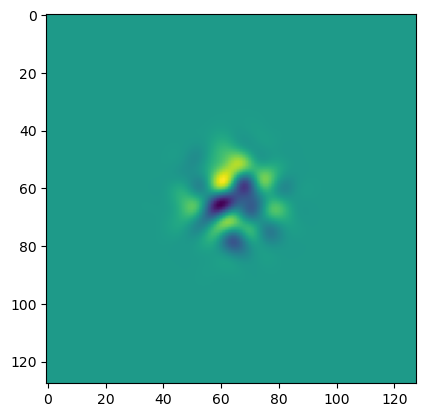

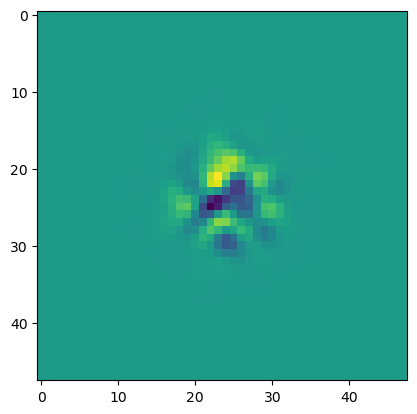

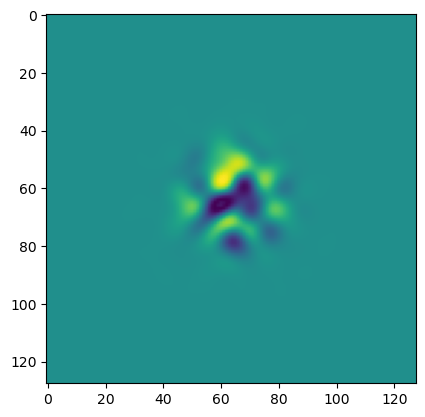

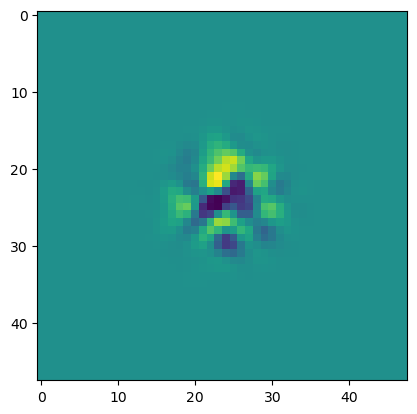

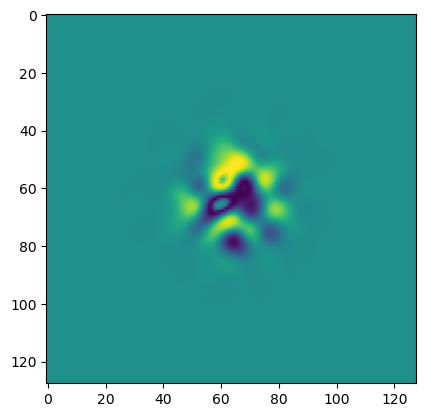

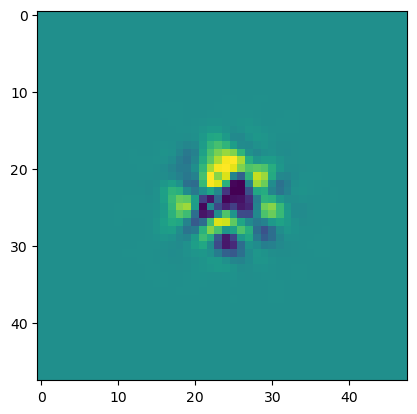

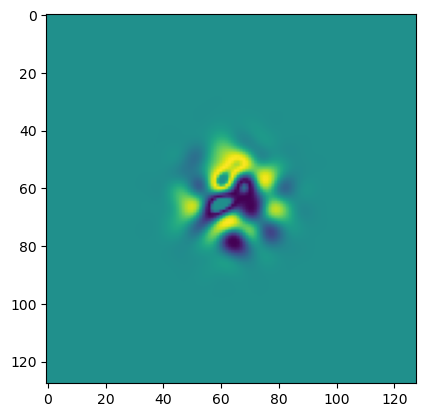

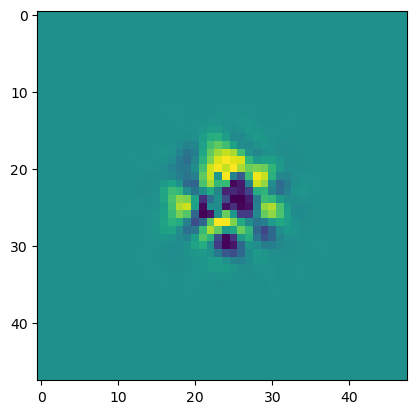

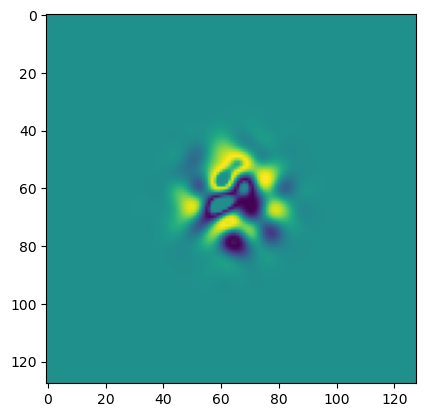

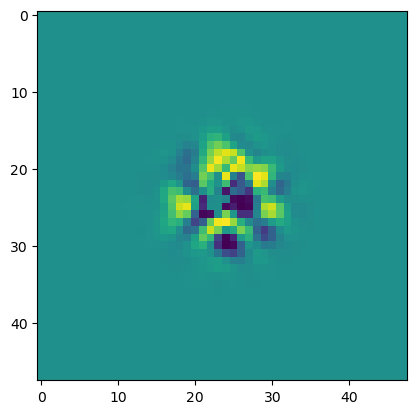

In [15]:
for i in range(50, 55):
    plt.imshow(total_fine_scale_dynamics_np[i])
    plt.show()
    plt.imshow(total_coarse_scale_dynamics_np[i])
    plt.show()

In [9]:
data = np.load(f'/pscratch/sd/h/hbassi/GS_model_multi_traj_data_coarse_scale_dynamics_1500_tmax=5_sigma={7}_numterms={20}.npy')
cg_data = data.reshape((1447, 50, 1, 48, 48))[:, :5, 0, :, :]
cg_data.shape

(1447, 5, 48, 48)

In [26]:
# Assume `data` is of shape (1447, 5, 48, 48)
time_zero_data = cg_data[:, 0, :, :]  # Extract the 0th time index, shape: (1447, 48, 48)

def frobenius_norm_differences(data_matrices, selected_idx):
    """
    Compare the Frobenius norm differences of a selected matrix to all others.

    Args:
        data_matrices (np.ndarray): Data of shape (num_samples, spatial_dim1, spatial_dim2).
        selected_idx (int): Index of the matrix to compare.

    Returns:
        np.ndarray: Array of Frobenius norm differences.
    """
    selected_matrix = data_matrices[selected_idx]  # Shape: (48, 48)
    # Compute Frobenius norm differences
    differences = np.linalg.norm(data_matrices - selected_matrix, axis=(1, 2))
    return differences

# Pick an index (e.g., index 0)
selected_index = 123
differences = frobenius_norm_differences(time_zero_data, selected_index)

# Print or analyze the differences
print(f"Frobenius norm differences for index {selected_index}: {differences}")


Frobenius norm differences for index 123: [ 7.49119228  5.21620398  2.65516752 ... 11.7397194   3.73624902
  4.1896448 ]


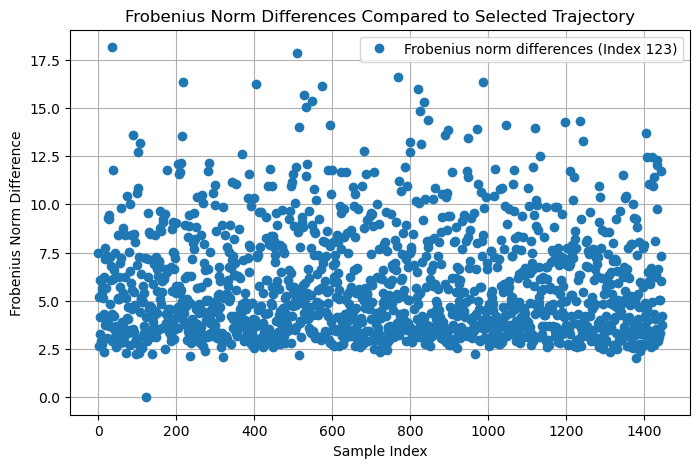

In [27]:
# Plot the differences
plt.figure(figsize=(8, 5))
plt.plot(differences, 'o', label=f'Frobenius norm differences (Index {selected_index})')
plt.xlabel('Sample Index')
plt.ylabel('Frobenius Norm Difference')
plt.title('Frobenius Norm Differences Compared to Selected Trajectory')
plt.legend()
plt.grid()
plt.show()


In [8]:
# def visualize_dynamics(fine_data, coarse_data, time_steps, Lx, Ly):
#     fine_Nx, fine_Ny = fine_data.shape[1:3]
#     coarse_Nx, coarse_Ny = coarse_data.shape[1:3]
    
#     x_fine = np.linspace(0, Lx, fine_Nx)
#     y_fine = np.linspace(0, Ly, fine_Ny)
#     x_coarse = np.linspace(0, Lx, coarse_Nx)
#     y_coarse = np.linspace(0, Ly, coarse_Ny)
    
#     X_fine, Y_fine = np.meshgrid(x_fine, y_fine, indexing='ij')
#     X_coarse, Y_coarse = np.meshgrid(x_coarse, y_coarse, indexing='ij')

#     fig, axes = plt.subplots(len(time_steps), 2, figsize=(12, 5 * len(time_steps)))
#     if len(time_steps) == 1:
#         axes = [axes]  # Ensure axes is iterable for a single time step

#     for i, t in enumerate(time_steps):
#         # Fine-scale plot
#         ax = axes[i][0]
#         im = ax.pcolormesh(X_fine, Y_fine, fine_data[t], shading='auto', cmap='hot')
#         fig.colorbar(im, ax=ax)
#         ax.set_title(f"Fine-scale at t={t}")
#         ax.set_xlabel("x")
#         ax.set_ylabel("y")

#         # Coarse-scale plot
#         ax = axes[i][1]
#         im = ax.pcolormesh(X_coarse, Y_coarse, coarse_data[t], shading='auto', cmap='hot')
#         fig.colorbar(im, ax=ax)
#         ax.set_title(f"Coarse-scale at t={t}")
#         ax.set_xlabel("x")
#         ax.set_ylabel("y")

#     plt.tight_layout()
#     plt.show()

# # Visualize for selected time steps
# time_steps_to_visualize = list(range(0, 100, 10))  
# visualize_dynamics(fine_scale_dynamics, coarse_scale_dynamics, time_steps_to_visualize, Lx, Ly)


In [9]:
fine_scale_dynamics.shape, coarse_scale_dynamics.shape

((10000, 128, 128), (10000, 48, 48))

In [30]:
with open('/pscratch/sd/h/hbassi/GS_model_data_fine_scale_dynamics.npy', 'wb') as f:
    np.save(f, np.expand_dims(fine_scale_dynamics[5000:][::10], 1))

In [31]:
with open('/pscratch/sd/h/hbassi/GS_model_data_coarse_scale_dynamics.npy', 'wb') as f:
    np.save(f, np.expand_dims(coarse_scale_dynamics[5000:][::10], 1))

In [12]:
fs_d = np.load('/pscratch/sd/h/hbassi/GS_model_data_fine_scale_dynamics.npy')[:,0,:,:]
cs_d = np.load('/pscratch/sd/h/hbassi/GS_model_data_coarse_scale_dynamics.npy')[:,0,:,:]

In [10]:
# import matplotlib.animation as animation
# # Set up figure
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# def update_plot(idx):
#     ax1.clear()
#     ax2.clear()

#     # Fine-scale dynamics
#     im1 = ax1.imshow(fs_d[idx], extent=[0, 100, 0, 100], origin='lower', cmap='hot')
#     ax1.set_title(f'Fine Scale at (t={500+ idx*1:.2f})')
#     ax1.set_xlabel('x')
#     ax1.set_ylabel('y')
    

#     # Coarse-grained dynamics
#     im2 = ax2.imshow(cs_d[idx], extent=[0, 100, 0, 100], origin='lower', cmap='hot')
#     ax2.set_title(f'Coarse Scale (t={500 + idx*1:.2f})')
#     ax2.set_xlabel('x')
#     ax2.set_ylabel('y')

# # Generate time indices to animate
# num_snapshots = fs_d.shape[0] # Number of snapshots to visualize
# time_indices = np.linspace(0, 749, num_snapshots, dtype=int)

# # Create an animation object
# ani = animation.FuncAnimation(fig, update_plot, frames=time_indices, repeat=False)

# # Save as a gif
# ani.save('dynamics_comparison.gif', writer='imagemagick', fps=25)  # Adjust fps as needed

# plt.show()
